In [1]:
import sys, warnings

import numpy as np
from scipy import signal as sg
import pandas as pd
import random as rnd

import xarray as xr

#import datetime
#from dateutil.rrule import DAILY,rrule
from time import gmtime, strftime, perf_counter

import matplotlib.pyplot as plt
#import matplotlib.colors as col
#import matplotlib.cm as cm

import statsmodels.api as sm

## Create a pseudo-random time series
* Use Fourier composition to control the resulting power spectrum
* Magnitude of each wavenumber $n$ is specified to give an expected spectrum
* $2^{11}$ points in the series
* Seed the generator so that we can reproduce the time series

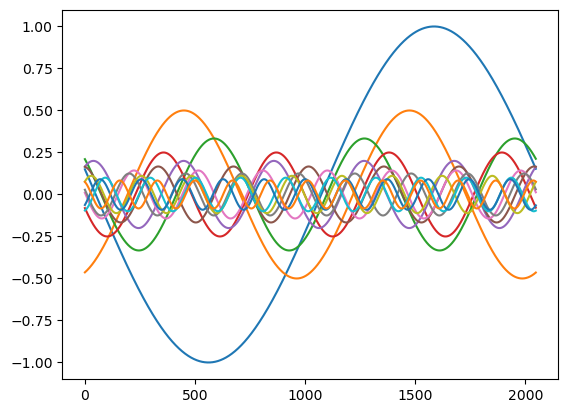

In [2]:
rng = np.random.default_rng(seed=42)
l = 2048
k = int(l/2)
phase = 2 * rng.random(l) * np.pi
waves = np.zeros((k,l))
a,b,mag = np.zeros(k),np.zeros(k),np.zeros(k)
for n in range(k):
    w = n + 1
    #mag[n] = 1 / abs(w - 5.516)
    mag[n] = 1 / w
    #mag[n] = np.exp(1-w/10)
    #mag[n] = 1 / np.sqrt(w)
    #mag[n] = 1
    sin_wave = np.array([np.sin(w*x/l*2*np.pi) for x in range(l)])
    cos_wave = np.array([np.cos(w*x/l*2*np.pi) for x in range(l)])
    a[n] = np.cos(phase[n]) ; b[n] = np.sin(phase[n])
    waves[n] = mag[n]*(a[n]*cos_wave+b[n]*sin_wave)

drift = 0.5 # Stick in a linear trend
series = waves.sum(axis=0)+np.linspace(-drift,drift,l)

for n in range(12): # Plot the first few waves so we can see their phases and magnitudes
    plt.plot(waves[n])

#### Add a linear trend to the time series to see:
1. What it causes to happen.
2. How to account for it.

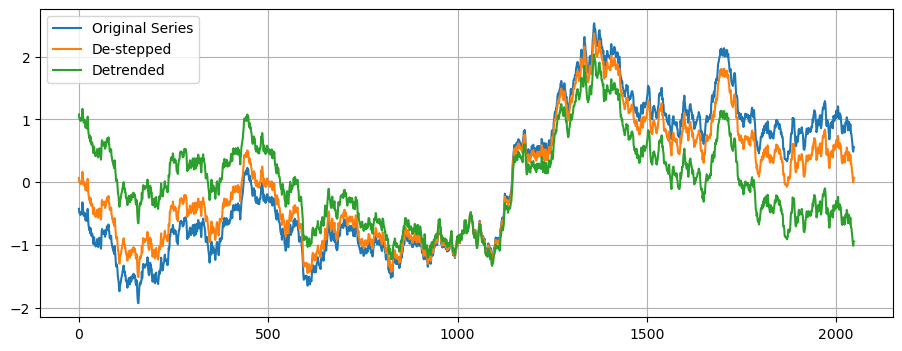

In [3]:
# Plot the constructed time series - we will test our alternative power spectrum calculation methods on this
fig = plt.figure(figsize=(11,4))
plt.plot(series,label="Original Series")
discon = 0.5*(series[0] - series[-1])
plt.plot(series-np.linspace(discon,-discon,l),label="De-stepped")
plt.plot(sg.detrend(series),label="Detrended")
plt.grid()
plt.legend() ;

## Standard method to find the power spectrum
Here we are using `scipy.signal` package to do a frequency decomposition and plot the power spectrum

Note the power of wavenumber $n$ is: $p_n = \frac{N}{2} m_n^2$ where:
* $N$ is the total number of points 
* $m_n$ is the magnitude of wavenumber $n$, which we defined as $1/n$
    
Given $X$ is the complete series composed of the sum of $N$ waves magnitude $m_n$:

$$ X(\omega) = \displaystyle\sum_{n=1}^{N} m_n (a_n \cos n\omega + b_n \sin n\omega) \qquad\qquad\qquad\qquad\qquad $$

where $\omega = 2\pi n / N$

The power spectral density for any wave $\omega$ (as calculated by the `periodogram` method below) is:

$$ S(\omega) = \frac{1}{N} X(\omega) \cdot X^{*}(\omega) \qquad\qquad\qquad\qquad\qquad $$

**Note:** If there is a step when the data wrap
(it wraps with a jump because the first and last values don't line up)
this gets jittery and does not pick up the spectrum as well.
* Standard detrending doesn't fix this
* Need to erase the step instead

array([5.44319163e-17, 1.31567564e+00, 4.64918211e-01, 4.20831210e-01,
       3.26448934e-01, 1.72289763e-01, 1.82025939e-01, 1.88240653e-01,
       1.63949615e-01, 8.86286810e-02, 9.56760174e-02])

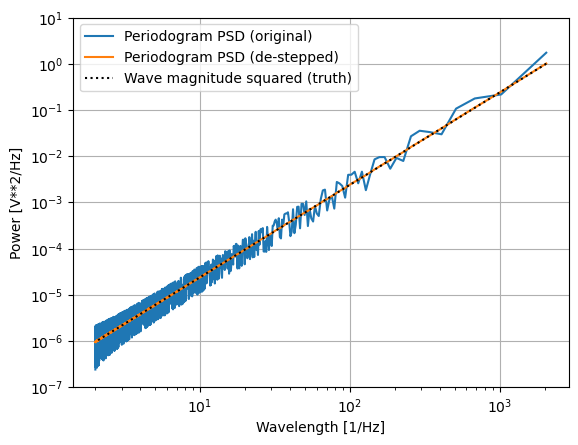

In [4]:
### Remove the discontinuity (call this "de-stepped")
destep = series - np.linspace(discon,-discon,l)
destep = destep - destep.mean()

### f is frequency (Hz relative to entire period); p is PSD (power spectral density)
f_o,p_o = sg.periodogram(series) # original
f_d,p_d = sg.periodogram(destep) # destepped

### Look at results
plt.loglog(1/f_o[1:-1], p_o[1:-1]/k, label="Periodogram PSD (original)")
plt.loglog(1/f_o[1:-1], p_d[1:-1]/k, label="Periodogram PSD (de-stepped)")
plt.loglog(1/f_o[1:-1], mag[:-1]**2, c='k', ls=':', label="Wave magnitude squared (truth)")
#plt.loglog(f_o[1:], pd.Series(p[1:]).rolling(32,min_periods=32,center=True).mean())
#plt.ylim([1e-7, 1e2])
y = [10**j for j in range(-7,2)]
plt.yticks(y)
plt.xlabel('Wavelength [1/Hz]')
plt.ylabel('Power [V**2/Hz]') 
plt.legend()
plt.grid();
np.sqrt(2*p_o/l)[:11]

## Lagged autocorrelation approach

Fourier transforms are the standard method to estimate power spectral density in a time series.

However, Fourier transforms require a complete time series - no missing data. 
This makes it impractical for use with most observational data sets, especially from poar-orbiting satellites.

Alternatively, Douce and Zhou (1988), note that power spectral density can be expressed in terms of autocovariance:

$$ S(\omega) = R(0) + 2 \displaystyle\sum_{\tau=1}^{N} R(\tau) \cos (\tau\omega) \qquad\qquad\qquad\qquad\qquad $$

where at lag $\tau$:

$$ R(\tau) = \frac{1}{N-\tau} \displaystyle\sum_{i=0}^{N-\tau} x_i x_{i+tau} \qquad\qquad\qquad\qquad\qquad $$

where $i$ is the index for the individual timesteps in the series composed of the total superposition of all waves.

Note that if we have periodic boundary conditions, then the equation above is not constrained by diminishing sample size at longer lags:

$$ R(\tau) = \frac{1}{N} \displaystyle\sum_{i=0}^{N} x_i x_{i+tau} \qquad\qquad\qquad\qquad\qquad $$

However, in such a case, the second half of the set (for $\tau > N/2$) will be a reflection of the first half, so can be neglected.

In [5]:
##############################################################
### Function to do lagged autocovariance skipping NaNs
#
# This works better than tsa.acovf, which seems to sacrifice accuracy for speed
#
def acovf_nan(x,nlag=None,adjusted=False,fillnan=True):
    if nlag == None:
        nlag = int(x.size/2 - 1)
    lacm = np.zeros(nlag+1)
    
    ### autocovariance loop
    for d in range(nlag+1):
        #print(0,nlag+1,d,nlag+d+1)
        lpm = x[:nlag+1] * x[d:nlag+d+1]
        if adjusted:
            lacm[d] = lpm[np.isfinite(lpm)].sum() / (nlag+1-d)
        else:
            lacm[d] = lpm[np.isfinite(lpm)].mean()
            
    if fillnan:
        ### Interpolate to fill any NaNs caused by periodic missing data
        not_nan = np.logical_not(np.isnan(lacm))
        indices = np.arange(len(lacm))
        lacm = np.interp(indices, indices[not_nan], lacm[not_nan])
    
    return lacm

##############################################################
### Function to smooth out ripples in data in frequency space
def freq_smooth(freq,psd,winfac=1):
    """
    Required inputs:
    freq   (float 1D array) = frequencies (ascending) [Hz]
    psd    (float 1D array) = corresponding power spectral density [v**2/Hz]
    
    Optional inputs:
    winfac          (float) = scaling factor for window size as function of frequency
    
    Output:
    smooth (float 1D array) = Smoothed version of psd
    """
    smooth = psd.copy()
    
    if freq.shape != psd.shape:
        raise IndexError("Required input series are not the same length")
        
    #win = np.rint(np.exp(freq*winfac))*2 - 1 # Window width
    win = np.rint(np.exp(np.sqrt(freq)*winfac))*2 - 1 # Window width
    for n in range(len(psd)):
        t0 = int((win[n]-1)/2)
        t1 = np.min((int((win[n]-1)/2)+1,len(psd)))
        smooth[n] = psd[n-t0:n+t1].mean()
    return smooth
    

In [6]:
### Create a double-length series by duplicating the data
wrap_o = np.append(series,series)
wrap_d = np.append(destep,destep)
kp1 = int(l/2) + 1
var_o = np.var(series) 
var_d = np.var(destep) 

### Calculate the set of lagged autocovariances
#lac = sm.tsa.acovf(wrapped,nlag=2047) # The lagged autocovariances as a series (wrapped)
#lact = sm.tsa.acovf(series)           # The lagged autocovariances as a series (truncated)

### adjusted=True: "denominators are n-k, otherwise n" it says at:
#   https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.acovf.html
#   This seems to give the right answer - above does not.
lac_wo = sm.tsa.acovf(wrap_o,adjusted=True,nlag=2047) # The lagged autocovariances as a series (wrapped)
lac_uo = sm.tsa.acovf(series,adjusted=True)           # The lagged autocovariances as a series (truncated)
lac_wd = sm.tsa.acovf(wrap_d,adjusted=True,nlag=2047) # The lagged autocovariances as a series (wrapped)
lac_ud = sm.tsa.acovf(destep,adjusted=True)           # The lagged autocovariances as a series (truncated)
lac_ad = acovf_nan(wrap_d,nlag=2047,adjusted=False)

### Calculate the PSD from autocovariances by the method of DZ88
pdz_wo  = np.array([2 * (lac_wo  * np.cos(n*2*np.pi*np.arange(l)/l)).sum() for n in range(kp1)])
pdz_uo  = np.array([2 * (lac_uo  * np.cos(n*2*np.pi*np.arange(l)/l)).sum() for n in range(kp1)])
pdz_wd  = np.array([2 * (lac_wd  * np.cos(n*2*np.pi*np.arange(l)/l)).sum() for n in range(kp1)])
pdz_ud  = np.array([2 * (lac_ud  * np.cos(n*2*np.pi*np.arange(l)/l)).sum() for n in range(kp1)])
pdz_wa  = np.array([2 * (lac_ad  * np.cos(n*2*np.pi*np.arange(l)/l)).sum() for n in range(kp1)])

### Fourier transform of autocovariance matrix approach:
pft_wo  = 2*np.abs(np.fft.rfft(lac_wo))[:kp1] 
pft_uo  = 2*np.abs(np.fft.rfft(lac_uo))[:kp1] 
pft_wd  = 2*np.abs(np.fft.rfft(lac_wd))[:kp1] 
pft_ud  = 2*np.abs(np.fft.rfft(lac_ud))[:kp1] 
pft_wa  = 2*np.abs(np.fft.rfft(lac_ad))[:kp1] 

#pac[1:]/2**10
#np.cov(series),np.sqrt(2*pac/l)[:11],2*np.sqrt(pact/l)[:11],2*np.sqrt(pft/l)[:11]/k,2*np.sqrt(pftt/l)[:11]/k

#### Plot the various approaches

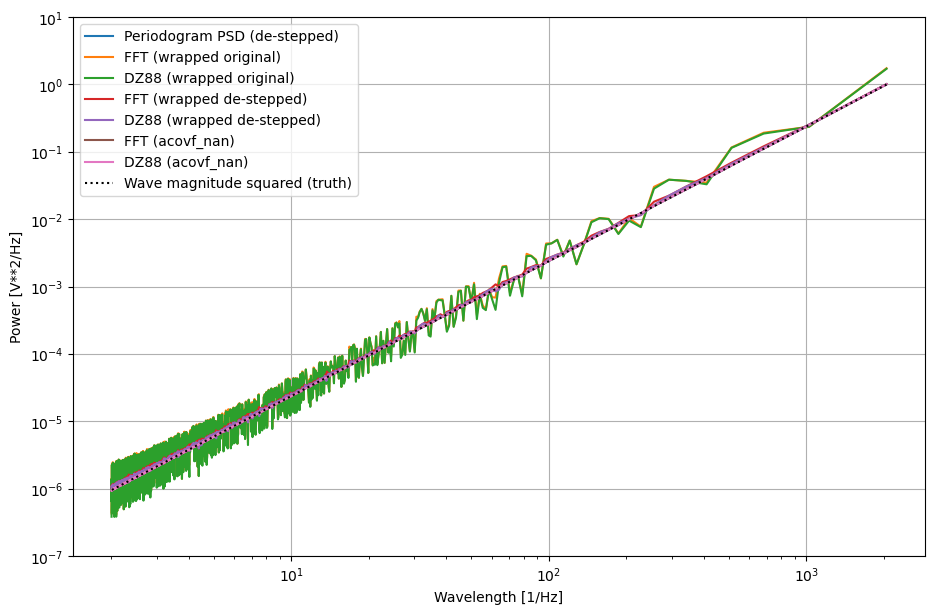

In [7]:
fig = plt.figure(figsize=(11,7))

#plt.loglog(1/f_o[1:-1], p_o[1:-1]/k, label="Periodogram PSD (original)")
plt.loglog(1/f_o[1:-1], p_d[1:-1]/k, label="Periodogram PSD (de-stepped)")

#plt.loglog(1/f_o[1:-1], pft_uo[1:-1]/k, ls='--', label="FFT (unwrapped original)")
#plt.loglog(1/f_o[1:-1], pft_ud[1:-1]/k, ls='-.', label="FFT (unwrapped de-stepped)")

#plt.loglog(1/f_o[1:-1], pdz_uo[1:-1]/k, ls='--', label="DZ88 (unwrapped original)")
#plt.loglog(1/f_o[1:-1], pdz_ud[1:-1]/k, ls='-.', label="DZ88 (unwrapped de-stepped)")

plt.loglog(1/f_o[1:-1], pft_wo[1:-1]/k, label="FFT (wrapped original)")
plt.loglog(1/f_o[1:-1], pdz_wo[1:-1]/k, label="DZ88 (wrapped original)")

plt.loglog(1/f_o[1:-1], pft_wd[1:-1]/k, label="FFT (wrapped de-stepped)")
plt.loglog(1/f_o[1:-1], pdz_wd[1:-1]/k, label="DZ88 (wrapped de-stepped)")

plt.loglog(1/f_o[1:-1], pft_wa[1:-1]/k, label="FFT (acovf_nan)")
plt.loglog(1/f_o[1:-1], pdz_wa[1:-1]/k, label="DZ88 (acovf_nan)")

plt.loglog(1/f_o[1:-1], mag[:-1]**2, c='k', ls=':', label="Wave magnitude squared (truth)")

y = [10**j for j in range(-7,2)]
plt.yticks(y)
plt.grid()
#plt.xlabel('Frequency [Hz]')
plt.xlabel('Wavelength [1/Hz]')
plt.ylabel('Power [V**2/Hz]') 
plt.legend() ;

### Conclusions

#### From the idealized analysis here:
1. It appears that a Fourier transform of the calculated autocovariances from the wrapped series returns a very good fit to the exact PSD calculated by the periodogram solution...
    * Without wrapping, there are dependencies on the nature of the spectrum that I can't figure out how to scale away without having prior knowledge of the spectrum.
    * It is necessary to adjust the series so that the first and last points line up before wrapping - otherwise the discontinuity introduces a lot of jitter into the spectrum.
        * Removing a linear trend conditioned on `(series[0] - series[-1])/2` works well
2. The Douce and Zhou (1988) method...
    * Is simpler than a full FFT: just a product with the right cosine.
    * It presumably is not sensitive to the "product of small primes" problem that FFTs have regarding series length.
3. The FFT method...
    * Apears to give a slightly larger value of PSD than DZ88 (see cell below) - further from the periodogram solution - presumably less accurate.
    * May be faster for big data - need to test this.

#### The autocorrelation series can be calculated in the presence of missing data. 
1. Douce and Zhou (1988) poses a method that needs to be explored - a way to imagine missing data as a complete time series multiplied by a mask series.
    * They propose that a separate autocovariance series needs to be calculated on the mask to adjust the estimated autocovariances from the incomplete data.
2. That is different from the approach we used in Dirmeyer and Norton (2018) - need to examine this next.

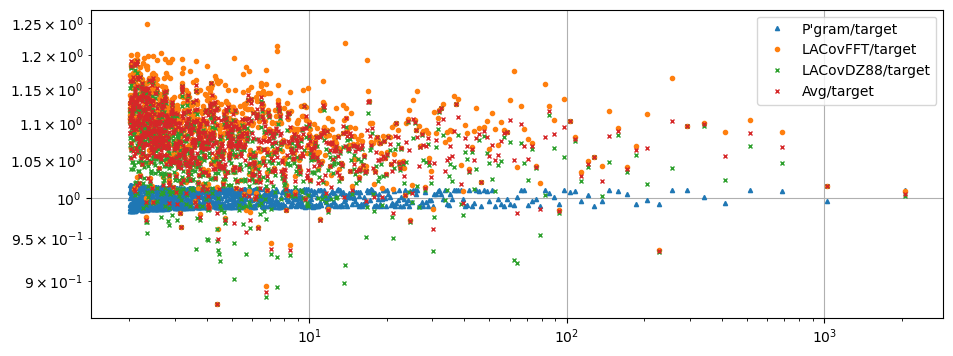

In [8]:
fig = plt.figure(figsize=(11,4))

#plt.loglog(1/f_o[1:-1], p[1:-1]/(2*pft[1:-1])*f_o[1:-1]*k/2)
plt.loglog(1/f_o[1:-1], p_d[1:-1]/k/mag[:-1]**2,'^',ms=3,label="P'gram/target")
plt.loglog(1/f_o[1:-1], pft_wd[1:-1]/k/mag[:-1]**2,'o',ms=3,label="LACovFFT/target")
plt.loglog(1/f_o[1:-1], pdz_wd[1:-1]/k/mag[:-1]**2,'x',ms=3,label="LACovDZ88/target")
plt.loglog(1/f_o[1:-1], (pft_wd[1:-1]+pdz_wd[1:-1])/2/k/mag[:-1]**2,'x',ms=3,label="Avg/target")
plt.grid()
plt.legend() ;

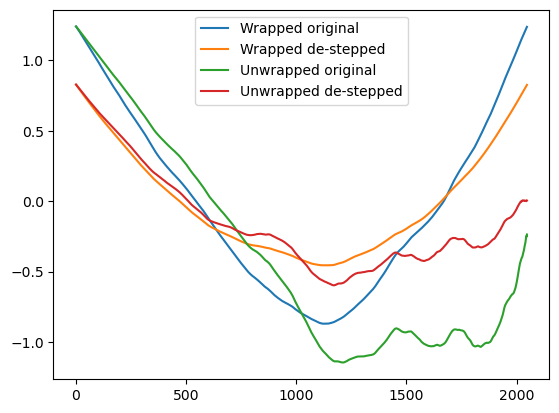

In [9]:
plt.plot(lac_wo,label="Wrapped original")
plt.plot(lac_wd,label="Wrapped de-stepped")
plt.plot(lac_uo,label="Unwrapped original")
plt.plot(lac_ud,label="Unwrapped de-stepped")
#plt.plot(sm.tsa.acovf(wrapped,nlag=2047),label="Wrapped")
#plt.plot(sm.tsa.acovf(series),label="Truncated")
plt.legend() ;

-----------------
-----------------
## With missing data...

Specify a fraction of timesteps to remove, pseudorandomly

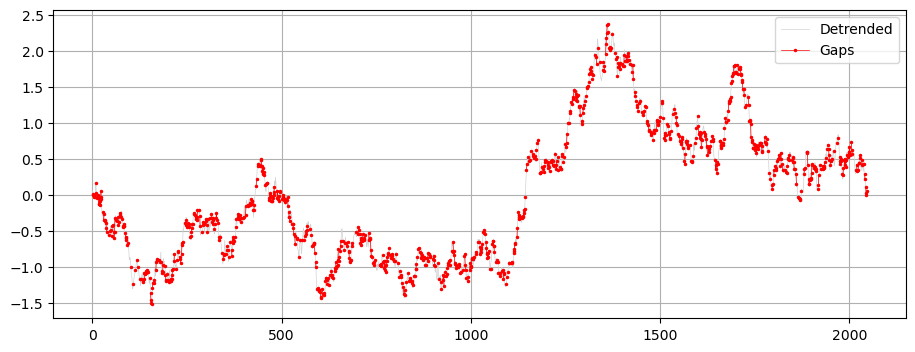

In [10]:
miss_frac = 0.0005
miss_frac = 0.01
miss_frac = 0.1
miss_frac = 0.3
miss_frac = 0.5

# We know at this point that destep is the way to go, so starting with it...
incomp = destep.copy()

### Randomply remove a percentage of points
for i in rnd.sample(range(l),int(l*miss_frac)):
    incomp[i] = np.nan

#
fig = plt.figure(figsize=(11,4))
plt.plot(destep,'lightgrey',lw=0.5,label="Detrended")
plt.plot(np.where(np.isfinite(incomp),np.nan,destep),'ro-',lw=0.5,ms=1.5,label="Gaps")
plt.grid()
plt.legend() ;

### Autocovariance with missing data

Only this approach can work with missing data

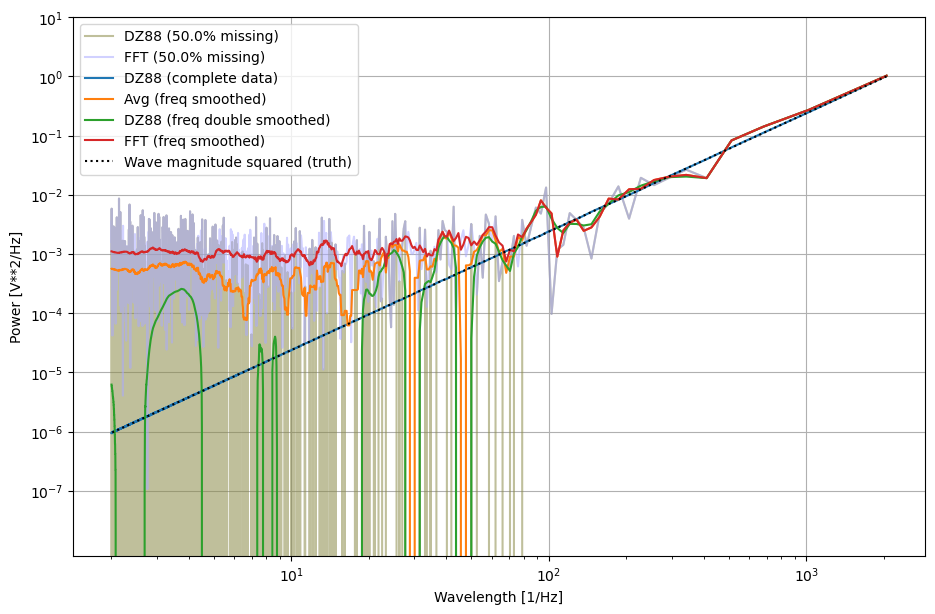

In [11]:
### Create a double-length series by duplicating the data
wrap_i = np.append(incomp,incomp)
var_i = incomp[~np.isnan(incomp)].mean() # Population variance

### Calculate the set of lagged autocovariances
#lac_wi = sm.tsa.acovf(wrap_i,adjusted=True,nlag=2047,missing='conservative') # The lagged autocovariances as a series (wrapped)
lac_wi = acovf_nan(wrap_i,nlag=2047,adjusted=False) # Incomplete data
lac_xx = acovf_nan(wrap_d,nlag=2047,adjusted=False) # Complete data

### Calculate the PSD from autocovariances by the method of DZ88
pdz_wi  = np.array([2 * (lac_wi  * np.cos(n*2*np.pi*np.arange(l)/l)).sum() for n in range(kp1)])
pdz_xx  = np.array([2 * (lac_xx  * np.cos(n*2*np.pi*np.arange(l)/l)).sum() for n in range(kp1)])

### Fourier transform of autocovariance matrix approach:
pft_wi  = 2*np.abs(np.fft.rfft(lac_wi))[:kp1] 
pft_xx  = 2*np.abs(np.fft.rfft(lac_xx))[:kp1] 

### Plot the comparison
fig = plt.figure(figsize=(11,7))

#plt.loglog(1/f_o[1:-1], p_d[1:-1]/k, label="Periodogram PSD")

plt.loglog(1/f_o[1:-1], pdz_wi[1:-1]/k, c="#88884488", label=f"DZ88 ({100*miss_frac:0.1f}% missing)")
plt.loglog(1/f_o[1:-1], pft_wi[1:-1]/k, c="#aaaaff88", label=f"FFT ({100*miss_frac:0.1f}% missing)")

plt.loglog(1/f_o[1:-1], pdz_xx[1:-1]/k, label="DZ88 (complete data)")
#plt.loglog(1/f_o[1:-1], pft_xx[1:-1]/k, label="FFT (complete data)")

win = 11
#wdz = pd.DataFrame(pdz_wi[1:-1]/k).rolling(win,center=True).mean()
#wft = pd.DataFrame(pft_wi[1:-1]/k).rolling(win,center=True).mean()
#w22 = pd.DataFrame((pdz_wi[1:-1]+pft_wi[1:-1])/(2*k)).rolling(win,center=True).mean()
#plt.loglog(1/f_o[1:-1], wft, label=f"FFT ({win}-wave# smoothed)")
#plt.loglog(1/f_o[1:-1], wdz, label=f"DZ88 ({win}-wave# smoothed)")
#plt.loglog(1/f_o[1:-1], w22, label=f"Avg ({win}-wave# smoothed)")

wss = freq_smooth(f_o[1:-1],(pdz_wi[1:-1]+pft_wi[1:-1])/(2*k),winfac=7.5)
wsd = freq_smooth(f_o[1:-1],pdz_wi[1:-1]/k,winfac=7.5)
wsd = freq_smooth(f_o[1:-1],wsd,winfac=7.5)
wsf = freq_smooth(f_o[1:-1],pft_wi[1:-1]/k,winfac=7.5)
plt.loglog(1/f_o[1:-1], wss, label=f"Avg (freq smoothed)")
plt.loglog(1/f_o[1:-1], wsd, label=f"DZ88 (freq double smoothed)")
plt.loglog(1/f_o[1:-1], wsf, label=f"FFT (freq smoothed)")

plt.loglog(1/f_o[1:-1], mag[:-1]**2, c='k', ls=':', label="Wave magnitude squared (truth)")

y = [10**j for j in range(-7,2)]
plt.yticks(y)
plt.grid()
#plt.xlabel('Frequency [Hz]')
plt.xlabel('Wavelength [1/Hz]')
plt.ylabel('Power [V**2/Hz]') 
plt.legend() ;


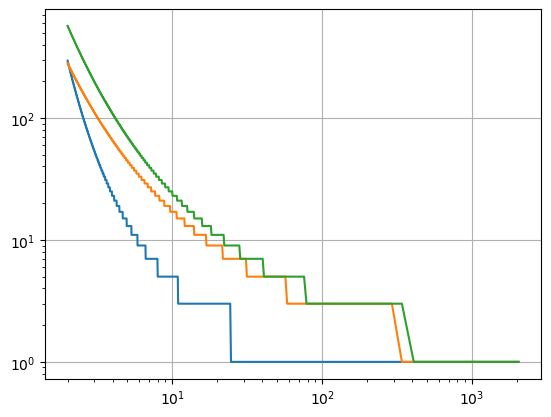

In [12]:
ff = f_o[1:-1]
#w = 2*(1.0*np.sqrt(ff*l))-1
w = np.rint(np.exp(ff*10))*2 - 1
plt.loglog(1/ff,w)
x = np.rint(np.exp(7*ff**0.5))*2 - 1
plt.loglog(1/ff,x) 
x = np.rint(np.exp(8*ff**0.5))*2 - 1
plt.loglog(1/ff,x) 
plt.grid() ;
#plt.semilogx(1/ff,w) ;

## Plot of sensitivity to missing data

1 point 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99  
1% 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99  
10% 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99  
30% 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 3

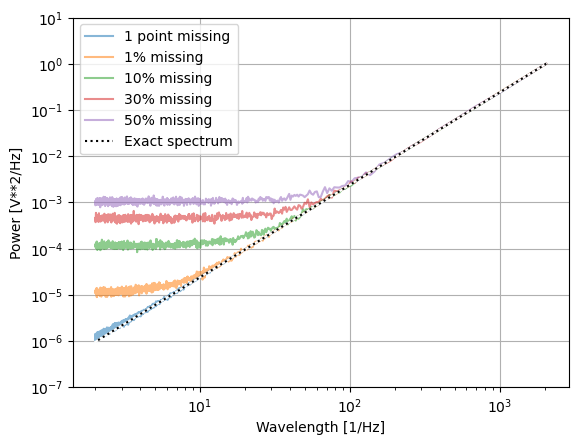

In [13]:
miss_frac = [0.0005,0.01,0.1,0.3,0.5]
title = ["1 point","1%","10%","30%","50%","SMAP 50%"]
colors = ["#1f77b488","#ff7f0e88","#2ca02c88","#d6272888","#9467bd88","#8c564b88"]
samp_size = 100

rng = np.random.default_rng(seed=42)
l = 2048
k = int(l/2)
kp1 = int(l/2) + 1

samp_mean = np.zeros((len(miss_frac),k-1))
samp_std = np.zeros((len(miss_frac),k-1))

### For each missing fraction, gin up 100 samples and average
for j,m in enumerate(miss_frac):
    acc = np.zeros(k-1)
    #acc2 = np.zeros(k-1)
    print(title[j],end=" ")
    
    ### A bunch of cases 
    for s in range(samp_size): 
        print(s,end=" ")
        
        if s%10 == 0:
            # Make a new timeseries with same power spectrum but randomized waves
            phase = 2 * rng.random(l) * np.pi
            waves = np.zeros((k,l))
            a,b,mag = np.zeros(k),np.zeros(k),np.zeros(k)
            for n in range(k):
                w = n + 1
                mag[n] = 1 / w
                sin_wave = np.array([np.sin(w*x/l*2*np.pi) for x in range(l)])
                cos_wave = np.array([np.cos(w*x/l*2*np.pi) for x in range(l)])
                a[n] = np.cos(phase[n])
                b[n] = np.sin(phase[n])
                waves[n] = mag[n]*(a[n]*cos_wave+b[n]*sin_wave)
            series = waves.sum(axis=0)
            ### Remove discontinuity and mean
            discon = 0.5*(series[0] - series[-1])
            destep = series - np.linspace(discon,-discon,l)
            destep = destep - destep.mean()
        if s == 0:
            f_d,p_d = sg.periodogram(destep) # destepped
        
        ### Randomly remove a percentage of points
        incomp = destep.copy()
        for i in rnd.sample(range(l),int(l*m)):
            incomp[i] = np.nan
        wrap_i = np.append(incomp,incomp)
        lac_wi = acovf_nan(wrap_i,nlag=2047,adjusted=False)  # Autocovariance series
        pft_wi  = 2*np.abs(np.fft.rfft(lac_wi))[:kp1]        # Fourier transform gives PSD
        #wsf = freq_smooth(f_d[1:-1],pft_wi[1:-1]/k,winfac=7.5) # Smooth along frequency 
        wsf = pft_wi[1:-1]/k
        acc = acc + wsf
        #acc2 = acc2 + wsf
            
    samp_mean[j] = acc / samp_size
    #samp_std[j] = np.sqrt(acc2 / samp_size)
    plt.loglog(1/f_d[1:-1], samp_mean[j], c=colors[j], label=f"{title[j]} missing")
    print(" ")
plt.loglog(1/f_d[1:-1], mag[:-1]**2, c='w')
plt.loglog(1/f_d[1:-1], mag[:-1]**2, c='k', ls=':', label="Exact spectrum")

y = [10**j for j in range(-7,2)]
plt.yticks(y)
plt.grid()
#plt.xlabel('Frequency [Hz]')
plt.xlabel('Wavelength [1/Hz]')
plt.ylabel('Power [V**2/Hz]') 
plt.legend() ;


SMAP 50% 0 

/var/folders/l7/8mb4_y1x541fmbrkjsc7cmf40000gp/T/ipykernel_34314/1041178122.py:35: RuntimeWarning: divide by zero encountered in double_scalars
  incomp[i] = incomp[i] / smap_mask[i%8]
/var/folders/l7/8mb4_y1x541fmbrkjsc7cmf40000gp/T/ipykernel_34314/3838255053.py:18: RuntimeWarning: Mean of empty slice.
  lacm[d] = lpm[np.isfinite(lpm)].mean()
/Users/dirmeyer/miniconda3/envs/CLIM614_2022/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

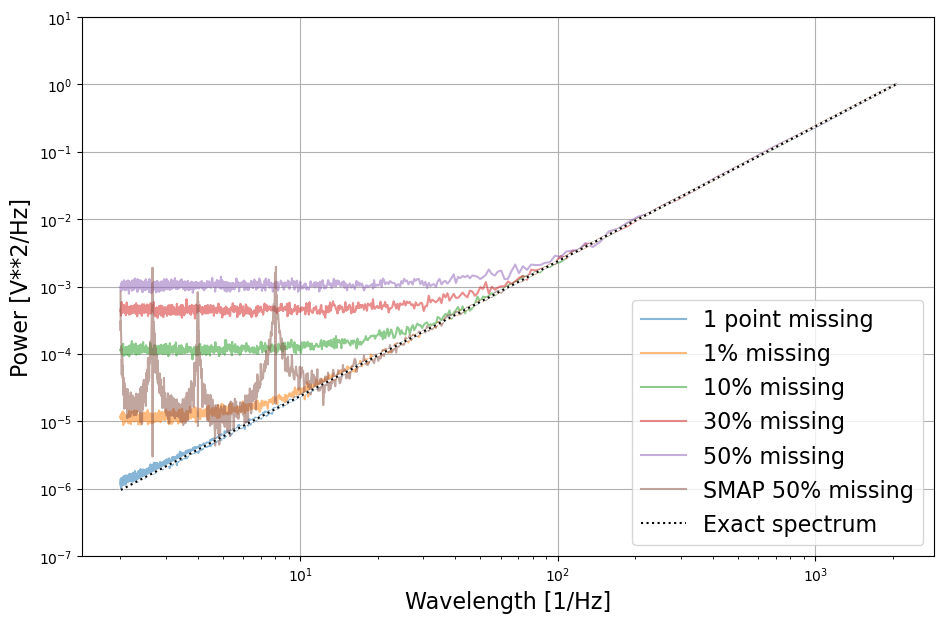

In [16]:
#Add in a SMAP pattern:
title = ["1 point","1%","10%","30%","50%","SMAP 50%"]
colors = ["#1f77b488","#ff7f0e88","#2ca02c88","#d6272888","#9467bd88","#8c564b88"]
j = 5
acc = np.zeros(k-1)
print(title[j],end=" ")

### A bunch of cases 
for s in range(samp_size): 
    print(s,end=" ")

    if s%10 == 0:
        # Make a new timeseries with same power spectrum but randomized waves
        phase = 2 * rng.random(l) * np.pi
        waves = np.zeros((k,l))
        a,b,mag = np.zeros(k),np.zeros(k),np.zeros(k)
        for n in range(k):
            w = n + 1
            mag[n] = 1 / w
            sin_wave = np.array([np.sin(w*x/l*2*np.pi) for x in range(l)])
            cos_wave = np.array([np.cos(w*x/l*2*np.pi) for x in range(l)])
            a[n] = np.cos(phase[n])
            b[n] = np.sin(phase[n])
            waves[n] = mag[n]*(a[n]*cos_wave+b[n]*sin_wave)
        series = waves.sum(axis=0)
        ### Remove discontinuity and mean
        discon = 0.5*(series[0] - series[-1])
        destep = series - np.linspace(discon,-discon,l)
        destep = destep - destep.mean()

    ### Remove the SMAP 50% pattern
    smap_mask = [1,1,0,1,0,0,1,0]
    incomp = destep.copy()
    for i in range(len(incomp)):
        incomp[i] = incomp[i] / smap_mask[i%8]
    wrap_s = np.append(incomp,incomp)
    lac_wst = acovf_nan(wrap_s,nlag=2047,adjusted=False,fillnan=True)  # Autocovariance series
    lac_wsf = acovf_nan(wrap_s,nlag=2047,adjusted=False,fillnan=False)  # Autocovariance series
    pft_ws  = 2*np.abs(np.fft.rfft(lac_wst))[:kp1]        # Fourier transform gives PSD
    #wsf = freq_smooth(f_d[1:-1],pft_wi[1:-1]/k,winfac=7.5) # Smooth along frequency 
    wsf = pft_ws[1:-1]/k
    acc = acc + wsf
    #acc2 = acc2 + wsf

smap = acc / samp_size


#
fig = plt.figure(figsize=(11,7))
ax = fig.add_subplot()
ax.set_xscale("log")
ax.set_yscale("log")

for j,m in enumerate(miss_frac):
    #ax.fill_between(1/f_d[1:-1], samp_mean[j]-samp_std[j], samp_mean[j]+samp_std[j], color=colors[j], alpha=0.3)
    ax.plot(1/f_d[1:-1], samp_mean[j], c=colors[j], label=f"{title[j]} missing")

j=5
ax.plot(1/f_d[1:-1], smap, c=colors[j], label=f"{title[j]} missing")
ax.plot(1/f_d[1:-1], mag[:-1]**2, c='w')
ax.plot(1/f_d[1:-1], mag[:-1]**2, c='k', ls=':', label="Exact spectrum")

y = [10**j for j in range(-7,2)]
ax.set_yticks(y)
ax.grid()
#plt.xlabel('Frequency [Hz]')
plt.xlabel('Wavelength [1/Hz]',fontsize=16)
plt.ylabel('Power [V**2/Hz]',fontsize=16) 
plt.legend(fontsize=16) ;

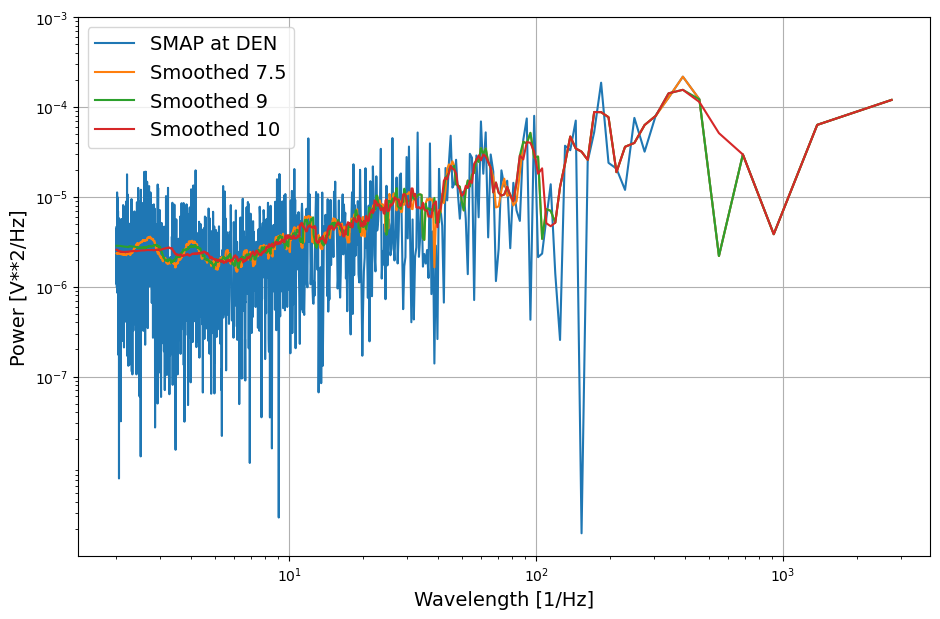

In [21]:
stn = "TUL"
stn = "DFW"
stn = "DEN"
ds_am = xr.open_dataset(f'/Users/dirmeyer/MyFiles/Data_Sets/SMAP/AMDAR/SMAP_AMDAR_am.{stn}.nc')
da_am = ds_am.soil_moisture.values

l = len(da_am)
k = int(l/2)
kp1 = int(l/2) + 1
f_o = np.arange(k+1)/l

# Find discontinuity when series is made periodic - remove it by linear trend
good = np.where(~np.isnan(da_am))[0]           # Indices where data is not missing
first,last = da_am[good[0]],da_am[good[-1]]   # First and last good data values
discon = 0.5 * (first - last)                   # Magnitude of discontinuity
destep = da_am - np.linspace(discon,-discon,l) # Remove discontinuity by linear trend
destep = destep - np.nanmean(destep)            # Remove grand mean
wrap_o = np.append(destep,destep)               # Wrap data by repeating the series
lac_o  = acovf_nan(wrap_o,adjusted=False,fillnan=True)   # Autocovariance 
pft_o  = 2*np.abs(np.fft.rfft(lac_o))[:kp1]              # Fourier transform gives power spectrum
w_o = pft_o[1:-1]/k                                      # Convert to PSD

fig = plt.figure(figsize=(11,7))
ax = fig.add_subplot()
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(1/f_o[1:-1], w_o, label=f"SMAP at {stn}")
w75 = freq_smooth(f_o[1:-1],w_o,winfac=7.5)
ax.plot(1/f_o[1:-1], w75, label=f"Smoothed 7.5")
w85 = freq_smooth(f_o[1:-1],w_o,winfac=8.5)
ax.plot(1/f_o[1:-1], w85, label=f"Smoothed 9")
w95 = freq_smooth(f_o[1:-1],w_o,winfac=10)
ax.plot(1/f_o[1:-1], w95, label=f"Smoothed 10")
#rr = pd.Series(w_o).rolling(32,min_periods=1,center=True).mean()
#ax.plot(1/f_o[1:-1], rr, label=f"Rolling")

y = [10**j for j in range(-7,-2)]
ax.set_yticks(y)
ax.grid()
plt.xlabel('Wavelength [1/Hz]',fontsize=14)
plt.ylabel('Power [V**2/Hz]',fontsize=14) 
plt.legend(fontsize=14) ;

/var/folders/l7/8mb4_y1x541fmbrkjsc7cmf40000gp/T/ipykernel_34314/3838255053.py:18: RuntimeWarning: Mean of empty slice.
  lacm[d] = lpm[np.isfinite(lpm)].mean()
/Users/dirmeyer/miniconda3/envs/CLIM614_2022/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


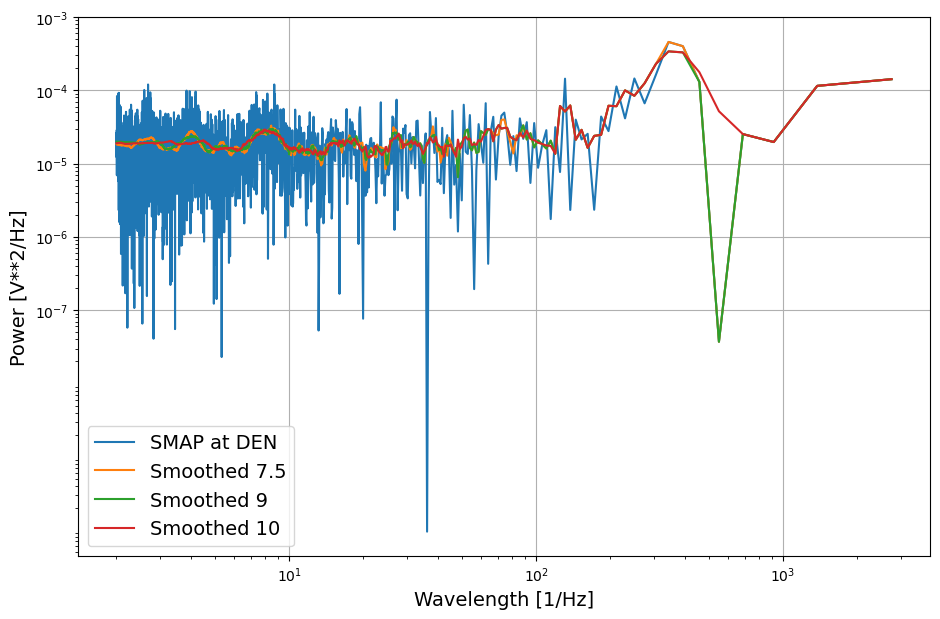

In [22]:
stn = "TUL"
stn = "DFW"
stn = "DEN"
ds_pm = xr.open_dataset(f'/Users/dirmeyer/MyFiles/Data_Sets/SMAP/AMDAR/SMAP_AMDAR_pm.{stn}.nc')
da_pm = ds_pm.soil_moisture_pm.values

l = len(da_pm)
k = int(l/2)
kp1 = int(l/2) + 1
f_o = np.arange(k+1)/l

# Find discontinuity when series is made periodic - remove it by linear trend
good = np.where(~np.isnan(da_pm))[0]           # Indices where data is not missing
first,last = da_pm[good[0]],da_pm[good[-1]]   # First and last good data values
discon = 0.5 * (first - last)                   # Magnitude of discontinuity
destep = da_pm - np.linspace(discon,-discon,l) # Remove discontinuity by linear trend
destep = destep - np.nanmean(destep)            # Remove grand mean
wrap_o = np.append(destep,destep)               # Wrap data by repeating the series
lac_o  = acovf_nan(wrap_o,adjusted=False,fillnan=True)   # Autocovariance 
pft_o  = 2*np.abs(np.fft.rfft(lac_o))[:kp1]              # Fourier transform gives power spectrum
w_o = pft_o[1:-1]/k                                      # Convert to PSD

fig = plt.figure(figsize=(11,7))
ax = fig.add_subplot()
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(1/f_o[1:-1], w_o, label=f"SMAP at {stn}")
w75 = freq_smooth(f_o[1:-1],w_o,winfac=7.5)
ax.plot(1/f_o[1:-1], w75, label=f"Smoothed 7.5")
w85 = freq_smooth(f_o[1:-1],w_o,winfac=8.5)
ax.plot(1/f_o[1:-1], w85, label=f"Smoothed 9")
w95 = freq_smooth(f_o[1:-1],w_o,winfac=10)
ax.plot(1/f_o[1:-1], w95, label=f"Smoothed 10")
#rr = pd.Series(w_o).rolling(32,min_periods=1,center=True).mean()
#ax.plot(1/f_o[1:-1], rr, label=f"Rolling")

y = [10**j for j in range(-7,-2)]
ax.set_yticks(y)
ax.grid()
plt.xlabel('Wavelength [1/Hz]',fontsize=14)
plt.ylabel('Power [V**2/Hz]',fontsize=14) 
plt.legend(fontsize=14) ;

In [ ]:
list(zip(w_o,rr))